In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt

In [2]:
def cokriging_model(X_width, X_depth, y, X_pred_width, X_pred_depth):
    # Perform ordinary kriging on width variable
    if X_width.shape[0] > 0:
        kriging_width = GaussianProcessRegressor(kernel=Matern(), normalize_y=True)
        kriging_width.fit(X_width, y)
        y_pred_width, y_pred_width_std = kriging_width.predict(X_pred_width, return_std=True)
    else:
        y_pred_width = np.zeros(X_pred_width.shape[0])
        y_pred_width_std = np.zeros(X_pred_width.shape[0])

    # Perform ordinary kriging on depth variable
    if X_depth.shape[0] > 0:
        kriging_depth = GaussianProcessRegressor(kernel=Matern(), normalize_y=True)
        kriging_depth.fit(X_depth, y)
        y_pred_depth, y_pred_depth_std = kriging_depth.predict(X_pred_depth, return_std=True)
    else:
        y_pred_depth = np.zeros(X_pred_depth.shape[0])
        y_pred_depth_std = np.zeros(X_pred_depth.shape[0])

    # Perform cokriging to combine predictions
    if X_width.shape[0] == 0:
        y_pred_cokriging = y_pred_depth
        y_pred_cokriging_std = y_pred_depth_std
    elif X_depth.shape[0] == 0:
        y_pred_cokriging = y_pred_width
        y_pred_cokriging_std = y_pred_width_std
    else:
        y_pred_cokriging = (y_pred_width + y_pred_depth) / 2.0
        y_pred_cokriging_std = np.sqrt((y_pred_width_std**2 + y_pred_depth_std**2) / 2.0)

    return y_pred_cokriging, y_pred_cokriging_std

 Model to apply Cokreiging method to data based on arguments
- The X_width and X_depth matrices represent width and depth. Each row in these matrices corresponds to a specific depth or width location, and the columns represent the value.

- y represents the target variable (soil moisture) for the corresponding depth and width data points.

- X_pred_depth and X_pred_width represent depth and width at unsampled locations where you want to make predictions.

- The GaussianProcessRegressor class from scikit-learn is used to perform ordinary kriging separately on the depth and width variables.

- The Matern kernel is chosen as an example for the Gaussian process regressor. You can choose a different kernel based on your data and requirements.

- The fit method is called to train the kriging models using the available data.

- The predict method is used to make predictions at the unsampled locations for both depth and width, and the standard deviations of the predictions are also obtained.

- The predictions from depth and width kriging models are combined using the cokriging equation (in this case, the average of the predictions).

- The standard deviation for the cokriging predictions is calculated based on the standard deviations from depth and width kriging models.

- Finally, the function returns the cokriging predictions (y_pred_cokriging) and their standard deviations (y_pred_cokriging_std).

The code checks the number of data points in the X_width and X_depth matrices to determine whether there are enough points to perform kriging. If there are no data points available, it sets the predictions to zero.

If the X_width matrix has no data points, the predictions for width-related variables are set to zero.

If the X_depth matrix has no data points, the predictions for depth-related variables are set to zero.

The cokriging step combines the predictions from width and depth if both matrices have data points available. If either X_width or X_depth has no data points, it uses the predictions from the available dataset as the cokriging predictions.

#### Gaussian Kriging Example:

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


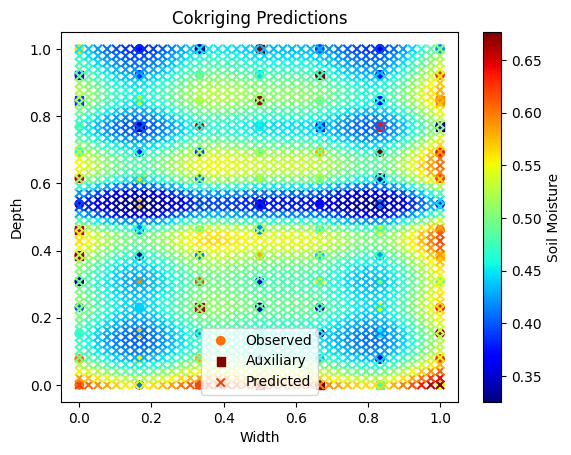

In [3]:
# Generate example data
np.random.seed(13)

# Grid parameters
N_width = 7  # Number of grid points in the width direction
M_depth = 14  # Number of grid points in the depth direction

# Generate grid coordinates
X_width_observed, X_depth_observed = np.meshgrid(np.linspace(0, 1, N_width), np.linspace(0, 1, M_depth))
X_width_observed = X_width_observed.flatten()[:, np.newaxis]
X_depth_observed = X_depth_observed.flatten()[:, np.newaxis]

# Generate random observed values
y_observed = np.random.rand(N_width * M_depth)

# Randomly select auxiliary data points from observed data
N_auxiliary = 20 # change this to be in the same collumn 
indices = np.random.choice(X_width_observed.shape[0], N_auxiliary, replace=False)
X_width_auxiliary = X_width_observed[indices]
X_depth_auxiliary = X_depth_observed[indices]
y_auxiliary = y_observed[indices]

# Predicted data (grid coordinates)
N_predicted = 40
M_predicted = 50
X_width_predicted, X_depth_predicted = np.meshgrid(np.linspace(0, 1, N_predicted), np.linspace(0, 1, M_predicted))
X_width_predicted = X_width_predicted.flatten()[:, np.newaxis]
X_depth_predicted = X_depth_predicted.flatten()[:, np.newaxis]

# Cokriging model
y_pred, y_pred_std = cokriging_model(
    np.concatenate([X_width_observed, X_width_auxiliary]),
    np.concatenate([X_depth_observed, X_depth_auxiliary]),
    np.concatenate([y_observed, y_auxiliary]),
    X_width_predicted,
    X_depth_predicted
)

# Plotting
plt.scatter(X_width_observed, X_depth_observed, c=y_observed, cmap='jet', label='Observed')
plt.scatter(X_width_auxiliary, X_depth_auxiliary, c=y_auxiliary, cmap='jet', marker='s', label='Auxiliary')
plt.scatter(X_width_predicted, X_depth_predicted, c=y_pred, cmap='jet', marker='x', label='Predicted')
plt.colorbar(label='Soil Moisture')
plt.xlabel('Width')
plt.ylabel('Depth')
plt.legend()
plt.title('Cokriging Predictions')
plt.show()

#### Next Steps:
- Edge correction 
- Observed samples are in the same collumn 
- Non Gaussian Kriging